<a href="https://colab.research.google.com/github/AleCava01/Synthesizing-the-Mind/blob/main/STM_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE (Variational Auto-Encoder)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Dataset


In [17]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, f)
                            for f in os.listdir(root_dir)
                            if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # "L" = grayscale
        if self.transform:
            img = self.transform(img)
        return img


In [18]:
img_size = 182

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

dataset = CustomImageDataset(root_dir="drive/MyDrive/PACS/Synthesizing_the_mind/coronal_2D_healthy_IOP_scanner", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


#Definizione del VAE

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim=img_size*img_size, hidden_dim=2048, latent_dim=64):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## Loss function

In [20]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    model.train()
    train_loss = 0
    for data in dataloader:
        data = data.view(-1, img_size*img_size).to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset):.4f}")


Epoch 1, Loss: 23721.6326
Epoch 2, Loss: 21237.8226
Epoch 3, Loss: 26340.1822
Epoch 4, Loss: 27203.3587
Epoch 5, Loss: 19408.3355
Epoch 6, Loss: 21880.4062
Epoch 7, Loss: 17654.8188
Epoch 8, Loss: 17215.1607
Epoch 9, Loss: 17506.0065
Epoch 10, Loss: 21334.9740
Epoch 11, Loss: 19001.1841
Epoch 12, Loss: 18225.3761
Epoch 13, Loss: 17936.2952
Epoch 14, Loss: 20412.3784
Epoch 15, Loss: 17652.6227
Epoch 16, Loss: 17472.3566
Epoch 17, Loss: 29745.1605
Epoch 18, Loss: 18101.7475
Epoch 19, Loss: 17365.0481
Epoch 20, Loss: 17293.2226
Epoch 21, Loss: 17309.1529
Epoch 22, Loss: 17826.5304
Epoch 23, Loss: 18729.4451
Epoch 24, Loss: 20624.5471
Epoch 25, Loss: 18690.9242
Epoch 26, Loss: 19353.6254
Epoch 27, Loss: 18504.5389
Epoch 28, Loss: 18203.4069
Epoch 29, Loss: 17922.0025
Epoch 30, Loss: 17693.9565
Epoch 31, Loss: 17366.2984
Epoch 32, Loss: 17296.4360
Epoch 33, Loss: 17213.6755
Epoch 34, Loss: 17266.4899
Epoch 35, Loss: 18256.7048
Epoch 36, Loss: 18641.6022
Epoch 37, Loss: 18121.5334
Epoch 38, 

# Sampling

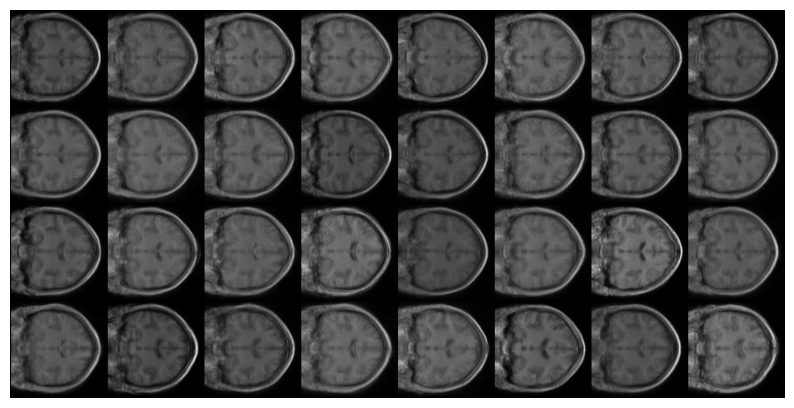

In [69]:
import torchvision
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = torch.randn(32, 64).to(device)
    samples = model.decode(z).cpu().view(-1, 1, img_size, img_size)
    grid = torchvision.utils.make_grid(samples, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()


#Conditional Variational Auto-Encoder (CVAE)

## Data Loading

In [40]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import os

# Colab: mount Google Drive se non l'hai fatto
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/PACS/Synthesizing_the_mind"

# Trasformazioni
transform = transforms.Compose([
    transforms.Resize((182, 182)),
    transforms.Grayscale(num_output_channels=1),  # Converti in scala di grigi
    transforms.ToTensor(),
])


# Funzione per validare solo file immagine
def is_valid_file(path):
    return path.lower().endswith(('.png', '.jpg', '.jpeg'))

# Dataset
dataset = ImageFolder(dataset_path, transform=transform, is_valid_file=is_valid_file)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Mappa etichette numeriche → nomi cartelle (scanner)
label_to_scanner = {i: name for i, name in enumerate(dataset.classes)}
print("Mapping etichette → scanner:", label_to_scanner)

# Test: stampa primo batch
images, labels = next(iter(dataloader))
print("Shape batch:", images.shape)
print("Etichette:", labels[:10])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mapping etichette → scanner: {0: 'coronal_2D_healthy_Guys_scanner', 1: 'coronal_2D_healthy_IOP_scanner', 2: 'coronal_2D_healthy_SALD_scanner', 3: 'coronal_2D_healthy_Triotim_scanner'}
Shape batch: torch.Size([64, 1, 182, 182])
Etichette: tensor([2, 2, 2, 2, 0, 1, 2, 2, 2, 2])


## CVAE Implementation

In [59]:
class CVAE(nn.Module):
    def __init__(self, input_dim=182*182, hidden_dim=2048, latent_dim=64, n_classes=4):
        super(CVAE, self).__init__()
        self.n_classes = n_classes
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim + n_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar

### Loss

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(n_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes).float()

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

for epoch in range(500):
    model.train()
    total_loss = 0
    for batch, labels in dataloader:
        batch = batch.view(batch.size(0), -1).to(device)          # [batch_size, 33124] + sposto su device
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=4).float().to(device)  # [batch_size, 4] + device

        recon, mu, logvar = model(batch, one_hot_labels)
        loss = loss_function(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.4f}")


Epoch 1, Loss: 20585.0869
Epoch 2, Loss: 16972.9029
Epoch 3, Loss: 16843.0835
Epoch 4, Loss: 16806.9775
Epoch 5, Loss: 16798.3069
Epoch 6, Loss: 16752.1453
Epoch 7, Loss: 16706.9440
Epoch 8, Loss: 16670.3418
Epoch 9, Loss: 16638.3569
Epoch 10, Loss: 16616.3905
Epoch 11, Loss: 16615.7297
Epoch 12, Loss: 16616.5362
Epoch 13, Loss: 16566.4866
Epoch 14, Loss: 16541.4223
Epoch 15, Loss: 16520.8542
Epoch 16, Loss: 16514.0144
Epoch 17, Loss: 16529.9872
Epoch 18, Loss: 16494.1561
Epoch 19, Loss: 16472.8339
Epoch 20, Loss: 16456.8210
Epoch 21, Loss: 16440.7205
Epoch 22, Loss: 16444.4714
Epoch 23, Loss: 16453.1672
Epoch 24, Loss: 16438.5043
Epoch 25, Loss: 16410.8774
Epoch 26, Loss: 16435.7646
Epoch 27, Loss: 16402.7857
Epoch 28, Loss: 16394.1724
Epoch 29, Loss: 16390.5274
Epoch 30, Loss: 16386.3134
Epoch 31, Loss: 16364.8158
Epoch 32, Loss: 16363.1563
Epoch 33, Loss: 16375.3139
Epoch 34, Loss: 16375.6237
Epoch 35, Loss: 16357.6440
Epoch 36, Loss: 16340.5878
Epoch 37, Loss: 16346.5904
Epoch 38, 

## Sampling

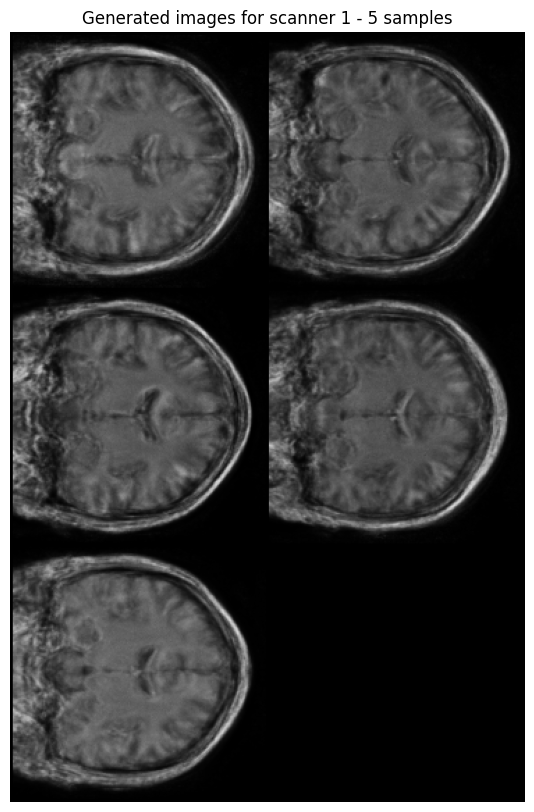

In [62]:
import matplotlib.pyplot as plt
import torchvision

model.eval()
num_samples = 5  # numero di immagini da generare
scanner_idx = 1   # scanner da cui generare immagini

with torch.no_grad():
    label = torch.tensor([scanner_idx] * num_samples).to(device)
    y = one_hot(label, n_classes).to(device)
    z = torch.randn(num_samples, model.latent_dim).to(device)

    samples = model.decode(z, y).cpu().view(-1, 1, img_size, img_size)

    # nrow può essere scelto per esempio come radice quadrata di num_samples
    nrow = int(num_samples ** 0.5)
    grid = torchvision.utils.make_grid(samples, nrow=nrow)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f"Generated images for scanner {scanner_idx} - {num_samples} samples")
    plt.show()
